*This notebook is a work in progress. Notes, comments and other suggestions should be sent to [olafur.bogason@mail.mcgill.ca](olafur.bogason@mail.mcgill.ca).*

# Wave Digital Filters
Wave Digital Filter theory is around fifty years old. It has very nice numerical properties, such as it preserves passitivity of the original circuit (no parasitic oscillations). Originally it was used to emulate RLC circuits that were decomposable into series and/or parallel subcircuits. This is very exciting times in WDF theory and I hope that this short introtuction will be of help for those wanting to get up to date with applying WDF to circuit emulation. What follows 

# Current status
The theory theory has grown quite a bit since it's beginnings, one can read about in Fettwei's monumental publication...Only recently has the set of circuits where this theory is applicable been extended to arbitrary topologies []. Nonlinear circuit components have been added one by one. 

Topics I want to cover in this notebook:
* Introduce the concept of WDFs and why they might be useful.
* How to map Kirchoff-domain (K-domain) variables (voltage/current) to Wave Digital-domain (WD-domain) variables (incident/reflected waves).
* Derivation of most common circuit element to the WD-domain.
* Derivation of adaptors (series, parallel).
* Examples of simple RCL circuits and comparison with LTSpice. 
    * Reference circuit
    * WDF derivation
    * SPQR tree
    * Audio examples, we need them for fun!
* Circuits in the wild have more complicated topologies, what can we do?
* What about circuits that contain op-amps?
* What about other non-linearities, such as diodes and/or transistors.
* Where to go from here?

To show, in code, how waves get propagated within adaptors and to hide away the nitty gritty maths, we slowly build up classes of one-port elements. I chose to let the adaptors be functions that lie outside and have the simulation loop be ad-hoc for each example.

In [165]:
# Basic framework
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt

FS = 96e3  # Sample frequency.
N = 2**14  # Number of points to simulate.

input = np.zeros(N)
input[0] = 1  # Input is a delta function.
output = np.zeros(input.size)
steps  = np.arange(N)

def plot_freqz(x, title="Frequency response"):
    w, h = signal.freqz(x, 1, 2048*2)
    H = 20 * np.log10(np.abs(h))
    f = w / (2 * np.pi) * FS
    plt.semilogx(f, H, label="WDF")
    plt.xlim([np.min(f), np.max(f)])
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')

def plot_ltspice_freqz(filename, title="Frequency response", out_label='V(vout)'):
    def imag2mag(z):
        # Returns the maginude of an imaginary number.
        a, b = map(float, z.split(','))
        return 20*np.log10(np.sqrt(a*a + b*b))
    
    x = pd.read_csv(filename, delim_whitespace=True)
    x['H_dB'] = x[out_label].apply(imag2mag)

    f = np.array(x['Freq.'])
    H_db = np.array(x['H_dB'])
    plt.semilogx(f, H_db, label="LTspice")


class WDFStructure(object):
    def __init__(self):
        self.a, self.b = 0, 0
        
    def wave_to_voltage(self):
        # Converts wave variables to voltage or current
        # depending on the value of Rp.
        return (self.a + self.b) / 2

# WD-domain variables
In this part of the introduction we will use the definition of voltage wave variables and derive the WDF representation for one port elements. One port elemets in electric circuits include components like resistors, capacitor and inductors. They also include ideal and resistive voltage and current sources along with short and open circuits.

We will do the derivation using concepts from circuit design such as the Laplace transform. Another key part of the derivation is the use of the bilinear transform to digitize the lumped analog circuit parts:

$$ s \leftarrow \frac{1}{2 f_s} \frac{z - 1}{z + 1} $$

To map voltages and currents to the wave domain variables, inciding- and reflected waves, a and b, we use the following linear transforms:

$$ a = v + i \cdot R_p \quad b = v - i \cdot R_p $$

and back again

$$ v = \frac{1}{2}(a + b) \quad i = \frac{1}{2 R_p}(a - b),  $$

There is one thing to bear in mind during this derivation. For the resulting WDF structure to be computable we cannot have any delay-free loops inside it. That means that for each one-port element we are looking for a function $f$ that maps $a$ -> $b$ but $b_t$ cannot depend on $a_t$ but only on delayed versions of $a$, for example$a_{t-1}$  (1). 

To deal with this issue we have two main tools at our disposal. We have one free parameter to work with, $R_p$, the port resistance, which gets introduced into the system physcially. The other tool is to make one port of a single adaptor reflection free. Meaning that we choose it's port resistance so that the reflected wave at that particular port does not depend on the incident wave of that port.

Photo of K-domain and WD-domain ports and the mappings from v, i to a, b


# One port elements
In this section we start with the K-domain representaion of a one-port element and derive the WD-domain counterpart. In the derivation process we use the transformation from K- to WD-domain extensively.

### WDF Resistor
A resistor is fully describe in lumped circuit theory by the voltage over it and current through it.

$$ Z_R = R = \frac{v}{i} = \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)} $$

$$ b = \frac{R - R_p}{R + R_p} a $$

Now for (1) to be fulfilled we need to have $R_p = R$. And now we see that $Z_R = 0$ so $b = 0$ for all resistor elements. The reflected wave is always zero, independent of the inciding wave! What does that mean? Will the resistors not contribute at all to the WDF structure? 

Far from it. As we will see when we look at connecting one-port elements together, the port resistances of each element will in fact contribute to the scattering of inciding waves at that given port.

In [166]:
class Resistor(WDFStructure):
    def __init__(self, R):
        self.a, self.b = 0, 0
        self.Rp = R
    
    def get_reflected_wave(self, a):
        self.a = a
        self.b = 0
        return self.b

### WDF Capacitor
Now we move on to reactive elements. and describe the capacitor as a function of the Laplace variable $s$.

$$ Z_C = \frac{1}{sC} = \frac{v}{i} = \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)} $$

$$ b = S a = \frac{1 - R_p C s}{1 + R_p C s} a $$

Now we use the bilinear transform and digitize the function S. Note here that there is no 

$$ b = S a = \frac{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L - R_p}{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L + R_p} a =  \frac{(1 - 2 f_s C R_p) + (1 +  2 f_s C R_p)z^{-1}}{(1 + 2 f_s C R_p) + (1 -  2 f_s C R_p)z^{-1}} a $$

We can now see that the only way (1) be fulfilled is if $R_p = \frac{1}{2f_sC}$. Plugging that result into the equation above we get that $ b = z^{-1} a $, which means that the reflected wave is simply a unit-delayed inciding wave.

In [167]:
class Capacitor(WDFStructure):
    def __init__(self, C):
        WDFStructure.__init__(self)
        self.Rp = 1 / (2 * FS * C)
    
    def get_reflected_wave(self, a):
        self.b = self.a
        self.a = a
        return self.b
    
    def get_incident_wave(self, a):
        self.a = a

### WDF Inductor
Following the same approach as above we can easilly derive the one port WD-domain adaptor for an inductor.

$$ Z_L = sL = \frac{v}{i} = \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)} $$

$$ b = S a = \frac{sL - R_p}{sL + R_p} a $$

Now we use the bilinear transform and digitize S. 

$$ b = S a = \frac{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L - R_p}{\frac{1}{2 f_s} \frac{z - 1}{z + 1}L + R_p} a = \frac{(2f_sL - R_p) - (2f_sL + R_p)z^{-1}}{(2f_sL + R_p) + (2f_sL - R_p)z^{-1}} a $$

Again we see that the only way (1) be fulfilled is if $R_p = 2 f_s L$. Plugging that result into the equation above we get that $b = - z^{-1} a$, which means that the reflected wave is a unit-delayed inciding wave with it's phase inverted.

In [168]:
class Inductor(WDFStructure):
    def __init__(self, L):
        WDFStructure.__init__(self)
        self.Rp = (2 * FS * L)
    
    def get_reflected_wave(self, a):
        self.b = self.a
        self.a = a
        return -self.b

### Short circuit
A short circuit can most easilly be seen as a resistor with no resistance, that is $R = 0$

$$ b = \frac{R - R_p}{R + R_p} a = -a$$

which essentially means that all the inciding wave gets projected back through the port.

### Open circuit
A short circuit can most easilly be seen as a resistor with infinite resitance, that is $R \rightarrow \infty$

$$ b = \frac{R - R_p}{R + R_p} a = \frac{R/R_p - 1}{R/R_p + 1} a = a$$

So the only difference of the relationship between a short - and open circuit is the sign. The sign can be interpreted as a phase change.

### Ideal Voltage Source
Picture

We can get the relationship in the case of an ideal voltage source with voltage $v_s$ directly from the definition of wave variables with respect to Kirchoff ones:

$$ v = \frac{1}{2}(a + b) \rightarrow b = 2v - a $$

In [169]:
class IdealVoltageSource(WDFStructure):
    def __init__(self):
        WDFStructure.__init__(self)
        
    def get_reflected_wave(self, a, vs=0):
        self.a = a
        self.b = 2*vs - a
        return self.b

### Ideal Current Source
The same is possible for the ideal current source with current $i_s$

$$ v = \frac{1}{2 R_p}(a - b) \rightarrow b = a - 2 R_p i$$

where $R_p$ is the port resistance and must be matched, which is a concept that we will cover in the next section.

In [170]:
class IdealCurrentSource(WDFStructure):
    def __init__(self):
        WDFStructure.__init__(self)
        
    def get_reflected_wave(self, a, i_s=0):
        self.a = a
        self.b = a - 2*R_p*i_s
        return self.b

### Resistive Voltage Source
Now what if we have an ideal voltage source with voltage $v_s$ connected in series with a resistor R? Then the Kirchoff voltage law gives us

$$ v = v_s + R i \\ b = 2v - a \\ = 2(v_s + R i) - a\\  = 2v_s + 2 R \frac{1}{2R_p}(a - b) - a$$

Now if we choose to have to have $R = R_p$ then we get 

$$ b = 2 v_s + a - b -a \\ b = v_s $$ 

In [171]:
class ResistiveVoltageSource(WDFStructure):
    def __init__(self, R):
        WDFStructure.__init__(self)
        self.Rp = R
    
    def get_reflected_wave(self, a, v_s=0):
        self.a = a
        self.b = v_s
        return self.b

### Resistive Current Source
What about a resistive current source? A resistive current source is essentially an ideal current source of magnitude $i_s$ connected in parallel with a resistor $R$. The voltage over the resistor can be quantified by $v = (i - i_s)R$ where $i$ is the current flowing into the port. We now have:

$$ b = a - 2 R_p i \\ = a - 2 R_p \frac{v}{R} + i_s R_p \\ = a - \frac{R_p}{R}(a + b) + 2 i_s R_p $$

Again if we choose to have $R = R_p$ then we get

$$ b = R i_s $$

In [172]:
class ResistiveCurrentSource(WDFStructure):
    def __init__(self, R):
        WDFStructure.__init__(self)
        self.Rp = R
    
    def get_reflected_wave(self, a, i_s=0):
        self.a = a
        self.b = self.Rp*i_s
        return self.b

### Table of results and interpretation
Voltage waves. How does voltage over a capacitor, inductor and resistor behave? What is interesting about these results?

# Adaptors for simple topologies
Now that we have a couple of one port elements laid out we cant start to connect them together. Typically circuits that have been emulated using WDFs have been connected in some seperable series and/or parallel conjunction. That is why we will start with them.

### Two-port simple adaptors
Now we will move to derive the relationship of reflected waves to incident waves of two-port series and parallel adaptors.

#### Series
Two port series adaptors are described by the following two equations:

$$ 0 = v_1 + v_2 \\ i_1 = i_2 = i_J $$

where $i_J$ is the current flowing into the junction.

$$ 0 = v_1 + v_2 = \frac{1}{2}(a_1 + b_1) + \frac{1}{2}(a_2 + b_2) \\ b_1 = -(a_2 + a_1) - b_2 $$

$$ 0 = i_2 - i_1 = \frac{1}{2R_2}(a_2 - b_2) - \frac{1}{2R_1}(a_1 - b_1) \\ a_2 - b_2 - \frac{R_2}{R_1}(a_1 = b_1) $$

$$ b_2 = \frac{R_1 - R_2}{R_1 + R_2}a_2 - \frac{2R_2}{R_1 + R_2}a_1 = -a_1 + \gamma(a_1 + a_2) $$

where $ \gamma = \frac{R_1 - R_2}{R_1 + R_2} $ as defined by Fettweis and used all over the place when scattering junctions appear. Now we can get the reflected wave at port 1.

$$ b_1 = -a_2 + \gamma(a_1 + a_2) $$

#### Parallel
We can derive the scattering relationship for parallel adaptors in a similar fashion. Conversely to the series adaptor the currents in the parallel adaptor sum up to zero but the voltages are all equal.

$$ 0 = i_1 + i_2 \\ v_1 = v_2 = v_J $$

where $v_J$ is defined as the voltage at the junction. Now we can use the definition of the wave variables and derive the relationship of reflected waves to the incident ones:

$$ 0 = i_1 + i_2 = \frac{1}{2R_1}(a_1 - b_1) +  \frac{1}{2R_2}(a_2 - b_2) $$

$$ 0 = R_2(a_1 - b_1) + R_1(a_2 - b_2) \\ b_1 = a_1 + \frac{R_1}{R_2}a_2 - \frac{R_1}{R_2}b_2 $$
 
And using equation ?? we can continue the derivation

$$ 0 = v_2 - v_1 = \frac{1}{2}(a_2 + b_2) - \frac{1}{2}(a_1 + b_1) = -a_1 + a_2 \frac{R_2 - R_1}{2 R_2} + b_2 \frac{R_2 + R_1}{2 R_2} \\ b_2 \frac{R_2 + R_1}{2 R_2} = a_1 - a_2 \frac{R_2 - R_1}{2 R_2}$$


$$ b_2 = \frac{2 R_2}{R_1 + R_2} a_1 - \frac{-R_1 + R_2}{R_1 + R_2} = a_1 + \gamma (a_2 - a_1) $$

$$  b_1 = a_1 + \frac{R_1}{R_2}a_2 - \frac{R_1}{R_2}b_2 \\ = a_1(1 - \frac{2 R_1}{R_1 + R_2}) + a_2(\frac{R_1}{R_2} - \frac{R_1}{R_2}\frac{R_1 - R_2}{R_1 + R_2}) \\ = a_2 + \gamma(a_2 - a_1)$$

Putting it together in vector format further shows us that we have a scattering matrix (rotation matrix + multiplication) in 2D space. In the case of a parallel adaptor we have:

$$
  \begin{matrix}\begin{pmatrix}b_1 \\ b_2 \end{pmatrix} \end{matrix}
  =
  \begin{pmatrix} -\gamma & 1 + \gamma \\ 1 - \gamma & \gamma \end{pmatrix}
  \begin{matrix}\begin{pmatrix}a_1 \\ a_2 \end{pmatrix} \end{matrix}
$$

And for the series adaptor we have:

$$
  \begin{matrix}\begin{pmatrix}b_1 \\ b_2 \end{pmatrix} \end{matrix}
  =
  \begin{pmatrix} \gamma & 1 - \gamma \\ 1 - \gamma & \gamma \end{pmatrix}
  \begin{matrix}\begin{pmatrix}a_1 \\ a_2 \end{pmatrix} \end{matrix}
$$

### N-port simple adaptors
Although N-port simple adaptors can always be broken up into 2- and 3-port adaptors we will still carry out the derivation for a variable N size (because it isn't really any harder and we love to generalize).

#### Series
As in the case of a 2-port series adaptor the adaptor can be described by it's voltages and currents:

$$ 0 = v_1 + v_2 + \dots + v_N \\ i_1 = i_2 = \dots = i_N$$

So now we can start working...

$$ 0 = v_1 + v_2 + \dots + v_N = (a_1 - R_1 i_1) + (a_2 - R_2 i_2) + \dots + (a_N - R_N i_N) \\  a_1 + a_2 + \dots + a_N - i (R_1 + R_2 + \dots + R_N) = 0 $$

$$ i = i_i = \frac{1}{2 R_i}(a_i - b_i) = \frac{1}{R_1 + R_2 + \dots + R_N}(a_1 + a_2 + \dots + a_N) \\ b_i = a_i - \frac{2 R_i}{R_1 + R_2 + \dots + R_N}(a_1 + a_2 + \dots + a_N)$$


#### Parallel
To save space and simplify calculations I put $G_i = \frac{1}{R_i}$

$$ 0 = i_1 + i_2 + \dots + i_N \\ v_1 = v_2 = \dots = v_N = v $$

$$ 0 = i_1 + i_2 + \dots + i_N = G_1(a_1 - v) + G_2(a_2 - v) + \dots + G_N(a_N - v) $$

$$ v = v_i =  \frac{1}{2}(a_i + b_i) = \frac{1}{G_1 + G_2 + \dots + G_N}(G_1 a_1 + G_2 a_2 + \dots + G_N a_N) $$

$$ b_i = \frac{2}{G_1 + G_2 + \dots + G_N}(G_1 a_1 + G_2 a_2 + \dots + G_N a_N) - a_i$$

In [173]:
def series_adaptor(A, R):
    Rtot = np.sum(R)
    Atot = np.sum(A)
    return [a - 2*r / Rtot * Atot for a, r in zip(A, R)]

def parallel_adaptor(A, R):
    G = [1/r for r in R]
    Gtot = np.sum(G)
    Gamma = [2*g / Gtot for g in G]
    aDotGamma = np.dot(A, Gamma)
    return [aDotGamma - a for a in A]


# On computability
Because we want our structures to be computable we cannot have any delay-free loops residing inside of them. That means that if we are to connect two adaptors together, or connect an element without its port resistance set, we are going to have to do something about it. 

One way is to *match* the port resistance of a port that has a delay-free relationship between its incident wave and reflected one. That way, due to the series/parallel equations that we have derived above, the reflected wave of that given port will not depend on the inc
ident wave at all.

Usually the way computalibity is ensured is to make up a SPQR tree of the circuit. SQPQ tree is an extension of the Binary Computation Tree as it allows for so called R-type adaptors which we will cover later. To see how to set-up a circuit in such a tree, please follow on to the next section.

# Examples

Now we will use the basic theory that we've learned and compute the magnitude response of some simple circuits. The code will be very generic and not make use of any object oriented concepts. Parties interested in seeing an OO approach for WDFs should consider [rt-wdf](https://github.com/m-rest/rt-wdf).

## Example - Resistive voltage source connected in series with RC

### WDF derivation
![WDF derivation for example 1](files/images/ex01_circuit.jpg)

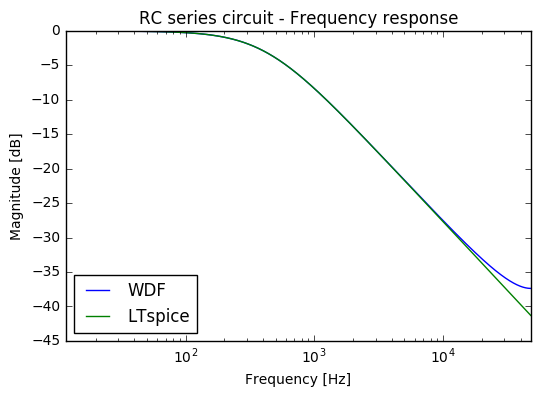

In [174]:
# One-port parameters.
V1 = ResistiveVoltageSource(1)  # 1 Ohm resistive volt. source
C1 = Capacitor(3.5e-5)          # 0.35 uF capacitor.
R1 = Resistor(10)               # 10 Ohm resistor.

# Adaptor parameters.
Rp1, Rp2, Rp3 = C1.Rp, R1.Rp, V1.Rp

# Simulation loop.
b1, b2, b3 = 0, 0, 0
for i in steps:
    # 1. Gather inputs and scatter them.
    a1 = C1.get_reflected_wave(b1)
    a2 = R1.get_reflected_wave(0)
    a3 = V1.get_reflected_wave(0, input[i])  # Read input signal off voltage source.
    
    a  = (a1, a2, a3)
    Rp = (Rp1, Rp2, Rp3)
    b1, b2, b3 = series_adaptor(a, Rp)

    # 2. Gather outputs.
    output[i] = C1.wave_to_voltage()  # Output is voltage over C1.
    C1.get_incident_wave(b1)          # Store new input inside Capacitor.

# Plot frequency response of the WDF simulation.
plot_freqz(output, title="RC series circuit - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("data/ex01.txt", title="Frequency response", out_label='V(vout)')

# Show the Frequency response
plt.legend(loc=3)
plt.show()

## Example - Resistive voltage source connected to RC, RL branches
![Reference circuit for example 1](files/images/ex03.png)

### WDF derivation
![WDF derivation for example 1](files/images/ex03_circuit.jpg)

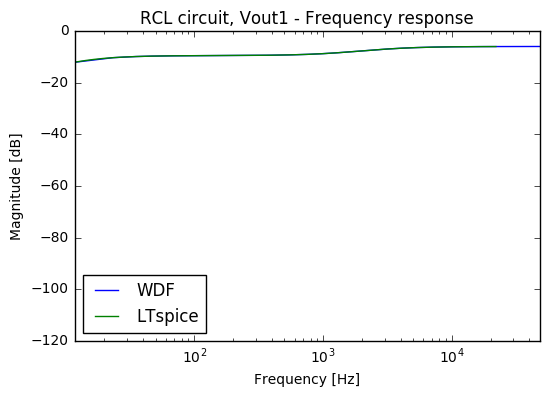

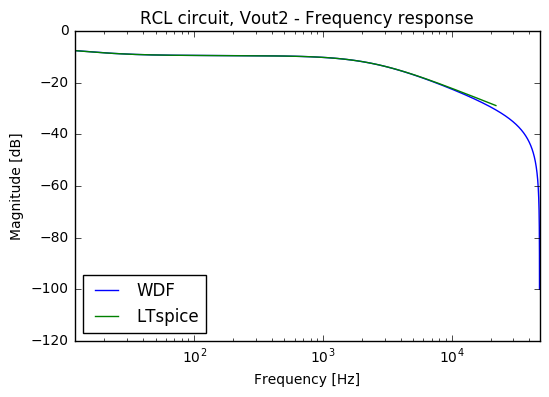

In [175]:
# Two outputs.
output_vout1 = np.zeros(input.size)
output_vout2 = np.zeros(input.size)

# One-port parameters.
V1 = 10  # Voltage source with 10 Ohm series resistor.
R2 = 10  # 10 Ohm resistor.
R3 = 10  # 10 Ohm resistor.
L1 = 2 * FS * 1e-3  # 1 mH Inductor.
C1 = 1 / (2 * FS * 1e-3)  # 1 mF Capacitor.

## Adaptor parameters.
# Series Port 2.
Rs22 = R3
Rs23 = L1
Rs21 = Rs22 + Rs23  # Matched port.
# Parallel Port. 
Rp2 = V1
Rp3 = Rs21
Rp1 = 1 / (1/Rp2 + 1/Rp3)  # Matched port.
# Series Port 1.
Rs11 = Rp1
Rs12 = C1
Rs13 = R2

C1_z1 = 0  # Memory inside capacitor.
L1_z1 = 0  # Memory inside inductor.

# Simulation loop.
ap1,  ap2,  ap3  = 0, 0, 0
as11, as12, as13 = 0, 0, 0
as21, as22, as23 = 0, 0, 0
for i in steps:
    # 1. Wave up.
    as22 = 0
    as23 = -L1_z1
    
    as2 = (as21, as22, as23)
    Rs2 = (Rs21, Rs22, Rs23)
    bs21, bs22, bs23 = series_adaptor(as2, Rs2)
    ap2 = input[i]  # Read signal from voltage source.
    ap3 = bs21
    
    ap = (ap1, ap2, ap3)
    Rp = (Rp1, Rp2, Rp3)
    bp1, bp2, bp3 = parallel_adaptor(ap, Rp)
    
    as11 = bp1
    as12 = C1_z1
    as13 = 0
    
    as1 = (as11, as12, as13)
    Rs1 = (Rs11, Rs12, Rs13)
    bs11, bs12, bs13 = series_adaptor(as1, Rs1)
    
    # 2. Wave down.
    ap1 = bs11
    ap = (ap1, ap2, ap3)
    Rp = (Rp1, Rp2, Rp3)
    bp1, bp2, bp3 = parallel_adaptor(ap, Rp)
    
    as21 = bp3
    as2 = (as21, as22, as23)
    Rs2 = (Rs21, Rs22, Rs23)
    bs21, bs22, bs23 = series_adaptor(as2, Rs2)

    output_vout1[i] = wave_to_kirchhoff(as13, bs13)  # Output is voltage through R2
    output_vout2[i] = wave_to_kirchhoff(as22, bs22)  # Output is voltage through R3
    C1_z1 = bs12
    L1_z1 = bs23

# Plot frequency response of the WDF simulation.
plot_freqz(output_vout1, title="RCL circuit, Vout1 - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("data/ex03_vout1.txt", title="Frequency response", out_label='V(vout1)')

# Show the Frequency responses
plt.legend(loc=0)  # Find best location of legend box.
plt.show()

# Plot frequency response of the WDF simulation.
plot_freqz(output_vout2, title="RCL circuit, Vout2 - Frequency response")

# Plot frequency response from LTspice
plot_ltspice_freqz("data/ex03_vout2.txt", title="Frequency response", out_label='V(vout2)')

# Show the Frequency responses
plt.legend(loc=0)  # Find best location of legend box.
plt.show()

# More complicated  topologies
Simple R-type adaptors derived using MNA. Show how three port parallel adaptor can be defined

Move onto more complicated topologies that **need** MNA + R-type adaptors.

# Wave Digital Filter Adaptors for Arbitrary Topologies and Multiport Linear Elements
## by Kurt James Werner, Julius O. Smith III, Jonathan S. Abe

[Link to paper](http://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_53.pdf).

## Main topics
Derive scattering matrix for arbitrary circuit topology using [Modified Nodal Analysis](https://www.swarthmore.edu/NatSci/echeeve1/Ref/mna/MNA3.html#Review) in the W-domain.

## Derivation of scattering matrix
We want to find a matrix $S$ so that 

$$ b = S a $$

For each port on a R-type adaptor we place a Thevenin equivalent circuit. We then apply the MNA method (circuit element stamps) in the K-domain and finally transfer that into the W-domain.

![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/image001.png)

$R$ is the resistor value in the Thévenin equivalent circuit, $R_p$ the WDF adaptor port resistance, $i$ is the current going into the port and $j$ is the source current.

Now we set $R = R_p, e = a, i = -j$ and remember the folowing equations that define the relationship between K-domain and the W-domain.

$$ a = v + R_p i, b = v - R_p i $$

and use these two equations to eliminate $v$ and $i$:

$$ b = a + 2 R_p j $$


![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/image002.png)

Then all we need to do is get $j$ out of this set of equations:

![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/image003.png)

Now we have the solution to the equation $ b = S a $ where

![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/image004.png)

mna_element_stamps.jpg
![WDF derivation for example 1](files/images/mna_element_stamps.jpg)

## Method applied to a previous example

![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/rlc_circuit_radaptor.jpg)



![WDF derivation for example 1](files/images/pr_arbitrary_wdf_adpators/sallen_key_lp.jpg)

# Op amps

Nullator and macromodel discussion.

Examples: Buffer and Sallen-Key filter

# Diodes

# Final thoughts

# Biliography and references

# LTspice files and other handy things